##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix: Image-to-image translation with a conditional GAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This Google Colab Notebook heavily buroows from the pix2pix example. 
How to build and train a conditional generative adversarial network (cGAN) called pix2pix that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of your network will contain:

- A generator with a [U-Net]([U-Net](https://arxiv.org/abs/1505.04597))-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).

Note that each epoch can take around 15 seconds on a single V100 GPU.



## Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import os
import sys 
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.experimental.numpy as tnp

In [2]:
running_local = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    nb_path = '/content/notebooks'
    os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
    sys.path.insert(0, nb_path)  # or append(nb_path)
except:
    running_local = True
    print("Running locally")

Mounted at /content/drive


Line to install pymedphys which has a gamma function. Libaray was saved to Google drive and is commented out.

In [ ]:
#!pip install --target=$nb_path pymedphys

In [7]:
!pip install SimpleITK
!pip install pymedphys
!pip install PlotScrollNumpyArrays

     |████████████████████████████████| 48.4 MB 29 kB/s 


In [4]:
#import SimpleITK as sitk
import pymedphys

In [5]:
!git clone --recurse-submodules -j8 https://github.com/brianmanderson/Data_Generators

Cloning into 'Data_Generators'...
remote: Enumerating objects: 1092, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 1092 (delta 43), reused 65 (delta 24), pack-reused 1006
Receiving objects: 100% (1092/1092), 524.35 KiB | 6.99 MiB/s, done.
Resolving deltas: 100% (689/689), done.
Submodule 'Image_Processors_Module' (https://github.com/brianmanderson/Image_Processors_Module.git) registered for path 'Image_Processors_Module'
Cloning into '/content/Data_Generators/Image_Processors_Module'...
remote: Enumerating objects: 1205, done.        
remote: Counting objects: 100% (873/873), done.        
remote: Compressing objects: 100% (387/387), done.        
remote: Total 1205 (delta 528), reused 735 (delta 392), pack-reused 332        
Receiving objects: 100% (1205/1205), 309.00 KiB | 5.52 MiB/s, done.
Resolving deltas: 100% (750/750), done.
Submodule path 'Image_Processors_Module': checked out 'f91603a2bedcc15981db54709e4c6d83

In [8]:
from Data_Generators.TFRecord_to_Dataset_Generator import DataGeneratorClass
from Data_Generators.Image_Processors_Module.src.Processors import TFDataSetProcessors as Processors

Pull a sample image.   There are 4 images in 1 that need to be reformatted. From left to right, ray trace projection of CBCT. Fluence Map, PDOS and RTImage

In [78]:
def return_generator(records_paths):
    generator = DataGeneratorClass(record_paths=records_paths)
    all_keys = ('pdos_array', 'drr_array', 'half_drr_array', 'fluence_array')
    base_processors = [
        Processors.Squeeze(image_keys=all_keys),
        Processors.ExpandDimension(axis=-1, image_keys=('pdos_array', 'drr_array', 'half_drr_array', 'fluence_array')),
        Processors.Resize_with_crop_pad(keys=all_keys, image_rows=[256 for _ in range(len(all_keys))],
                                        image_cols=[256 for _ in range(len(all_keys))],
                                        is_mask=[False for _ in range(len(all_keys))]),
        Processors.Add_Constant(keys=all_keys,
                                values=(-255/2, -255/2, -255/2, 0)),
        Processors.MultiplyImagesByConstant(keys=all_keys, values=(2/255, 2/255, 2/255, 1/255)),
        Processors.CombineKeys(axis=-1, image_keys=('pdos_array', 'drr_array', 'half_drr_array'),
                               output_key='combined'),
        Processors.ReturnOutputs(input_keys=('combined',), output_keys=('fluence_array',)),
        {'shuffle': len(generator) // 3}, {'batch': 1}, {'repeat'}
        ]
    generator.compile_data_set(image_processors=base_processors, debug=False)
    return generator

In [79]:
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def load_data(file_references, mode, data_path):
    
    data = {'input' : [], 'rtimg' : [], 'fname' : []}
    
    # We define a `read_fn` and iterate through the `file_references`, which
    # can contain information about the data to be read (e.g. a file path):
    idx = 0
    for file in file_references:
        #print(file)     
        # Here, we parse the `subject_id` to construct a file path to read
        # an image from.
        #subject_id = meta_data[0]
        t1_fn = os.path.join(data_path,file)
        
        # Read the .nii image containing a brain volume with SimpleITK and get 
        # the numpy array:
        
        sitk_t1 = sitk.ReadImage(t1_fn)
        t1 = sitk.GetArrayFromImage(sitk_t1)
        #print(t1.shape)
        # Normalise the image to zero mean/unit std dev:
        # t1 = whitening(t1)
        # Normalize use the max value of PDOS which is 3.46
        # Max value of RT is 2.26 
        # Create a 4D Tensor with a dummy dimension for channels
        tinput = (t1[:, :, 1:4] /255.5 ) -1
        #tslice = (t1[:, :, 16] /127.5 ) -1
        #tpdos = (t1[:, :, 1] /127.5 ) -1
        #tcbct = tf.stack([tslice,tpdos],2)
        trt = (t1[:, :, 0,np.newaxis] / 255.5)-1
         
        tinput = tf.cast(tinput, tf.float32)
        trt = tf.cast(trt,  tf.float32)
        #tcbct = tf.squeeze(tcbct,axis=0)
        #print("CBCT shape " + str(tcbct.shape))
        #print("RT image shape " + str(trt.shape))
        
        data['input'].append(tinput)
        data['rtimg'].append(trt)
        data['fname'].append(str(file))
        #data['labels'].append(idx)
        idx = idx+1
            
    return data

In [17]:
def load_data_from_generator(generator):
  data = {'input' : [], 'rtimg' : []}
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    data['input'].append(x[0][0])
    data['rtimg'].append(y[0][0])
  return data

# Return a train and validation dataset based on which fold you want to exclude

In [46]:
def return_datasets(data_generators):
  all_datasets = {}
  for i in data_generators.keys():
    generator = data_generators[i]
    all_datasets[i] = tf.data.Dataset.from_tensor_slices((load_data_from_generator(generator)))
  return all_datasets

def return_fold_datasets(data_generators, batch_size=1):
  all_datasets = return_datasets(data_generators)

  train_dataset = all_datasets['train']
  train_dataset.shuffle(len(train_dataset))
  train_dataset = train_dataset.batch(batch_size)
  
  valid_dataset = all_datasets['validation']
  valid_dataset = valid_dataset.shuffle(len(valid_dataset))
  valid_dataset = valid_dataset.batch(batch_size)
  return train_dataset, valid_dataset

In [50]:
def return_generators(excluded_fold=5):
  data_generators = {}
  train_folder_names = []
  val_folder_names = []
  for i in range(1,6):
    folder_name = '/content/drive/My Drive/data/fold{}'.format(i)
    if i != excluded_fold:
      train_folder_names.append(folder_name)
    else:
      val_folder_names.append(folder_name)
  data_generators['train'] = return_generator(records_paths=train_folder_names)
  data_generators['validation'] = return_generator(records_paths=val_folder_names)
  return data_generators

In [81]:
data_generators = return_generators(excluded_fold=5)
train_dataset, valid_dataset = return_fold_datasets(data_generators, batch_size=BATCH_SIZE)

In [82]:
len(train_dataset)

552

In [ ]:
# Load all data into memory
#fold1_data = load_data(fold1, tf.estimator.ModeKeys.TRAIN, '/content/drive/My Drive/train/nifti/fold1')
fold2_data = load_data(fold2, tf.estimator.ModeKeys.TRAIN, '/content/drive/My Drive/train/nifti/fold2')
fold3_data = load_data(fold3, tf.estimator.ModeKeys.TRAIN, '/content/drive/My Drive/train/nifti/fold3')
fold4_data = load_data(fold4, tf.estimator.ModeKeys.TRAIN, '/content/drive/My Drive/train/nifti/fold4')
fold5_data = load_data(fold5, tf.estimator.ModeKeys.TRAIN, '/content/drive/My Drive/train/nifti/fold5')
#print(type(data))

#dataset = tf.data.Dataset.from_tensor_slices((x,y))
train_dataset = tf.data.Dataset.from_tensor_slices((fold2_data))
train_dataset2 = tf.data.Dataset.from_tensor_slices((fold3_data))
train_dataset3 = tf.data.Dataset.from_tensor_slices((fold4_data))
train_dataset4 = tf.data.Dataset.from_tensor_slices((fold5_data))
#train_dataset5 = tf.data.Dataset.from_tensor_slices((fold5_data))

train_dataset = train_dataset.concatenate(train_dataset2)
train_dataset = train_dataset.concatenate(train_dataset3)
train_dataset = train_dataset.concatenate(train_dataset4)

BUFFER_SIZE = len(list(train_dataset.as_numpy_iterator()))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
#print(train_dataset)
train_dataset = train_dataset.batch(BATCH_SIZE)
print(BUFFER_SIZE)
#iterator = iter(train_dataset)

#nx = next(iterator)
#print(type(iterator))

In [ ]:
fold1_data = load_data(fold1, tf.estimator.ModeKeys.TRAIN, '/content/drive/My Drive/train/nifti/fold1')
#print(type(datav))

valid_dataset = tf.data.Dataset.from_tensor_slices((fold1_data))
#valid_dataset = tf.data.Dataset.from_tensors((datav))
#valid_dataset = tf.data.Dataset.from_tensor_slices((datav))
valid_dataset = valid_dataset.shuffle(len(list(valid_dataset.as_numpy_iterator())) )
valid_dataset = valid_dataset.batch(BATCH_SIZE)
#print(type(valid_dataset))
#print(train_dataset)
print(len(list(valid_dataset.as_numpy_iterator())))

In [ ]:
  iterator = iter(validation_generator.data_set)
  for _ in range(len(validation_generator)):
      x,y = next(iterator)
      inp1 = x[0][0, :, 128 ,0]
      plt.plot(inp1)
  plt.figure()
  plt.imshow(x[0][0,...,2])

NameError: ignored

In [ ]:
if not running_local:
  for val in valid_dataset.take(1):
    inp = val['input']
    inp1 = tf.squeeze(inp,axis=0)
    vec = inp1[1:256,128]
    plt.plot(vec)
    print(tf.shape(inp1))

NameError: ignored

In [21]:
def getinput(input_image,chan):
    slice_image = input_image[:,:,chan]
    slice_image = tf.cast(slice_image, tf.float32)
    return slice_image

In [ ]:
slicen = 2
for val in train_dataset.take(1):
  inp = tf.squeeze(val['input'],axis=0)
  #print(tf.shape(inp))
  img = getinput(inp,slicen)
  print(tf.shape(img))


plt.figure()
#plt.imshow(tf.squeeze(img, axis=-1))
plt.imshow(img)

NameError: ignored

tf.Tensor([  1 256 256   1], shape=(4,), dtype=int32)
tf.Tensor([256 256], shape=(2,), dtype=int32)


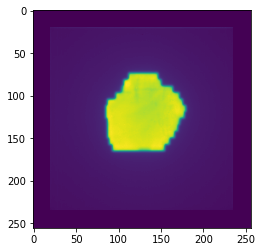

In [ ]:
for val in train_dataset.take(1):
  img = val['rtimg']
  print(tf.shape(img))

img = tf.squeeze(img, axis=0)
img = tf.squeeze(img, axis=-1)
#img = tf.cast(img, tf.float32)
print(tf.shape(img))
#plt.figure()
#plt.imshow(tf.squeeze(img, axis=-1))
plt.imshow(img)

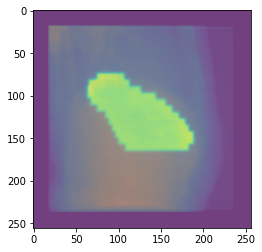

In [ ]:
slicen =1
for val in train_dataset.take(1):
  inp = tf.squeeze(val['input'],axis=0)
  img1 = getinput(inp,slicen)
  img2 = val['rtimg']
  img2 = tf.squeeze(img2, axis=0)
  #print(tf.shape(img))

#img2 = tf.cast(img2, tf.float32)
plt.figure()
plt.imshow(img1,alpha=0.5)
plt.imshow(tf.squeeze(img2, axis=-1),alpha=0.5)

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), you need to apply random jittering and mirroring to preprocess the training set.

Define functions that:

1. Randomly flip the image horizontally i.e. left to right (random mirroring).
2. Normalize the images to the `[-1, 1]` range. 

In [22]:
OUTPUT_CHANNELS = 1

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  #stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_input = tf.image.random_crop(input_image, size=[256, 256, 3])
  cropped_real = tf.image.random_crop(real_image, size=[256, 256, 1])

  return cropped_input, cropped_real

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  #input_image, real_image = resize(input_image, real_image, 286, 286)
  # Random cropping back to 236x236
  #input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_up_down(input_image)
    real_image = tf.image.flip_up_down(real_image)

  return input_image, real_image

You can inspect some of the preprocessed output:

In [23]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Define the upsampler (decoder):

In [24]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print (up_result.shape)

Define the generator with the downsampler and the upsampler:

In [83]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

In [31]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
#generator.summary()

Test the generator:

In [ ]:
print(tf.shape(inp))
print(tf.shape(inp[tf.newaxis, ...]))

gen_output = generator(inp[tf.newaxis, ...], training=False)
#print(tf.shape(gen_output))
plt.imshow(tf.squeeze(gen_output[0, ...],axis=-1))

NameError: name 'inp' is not defined

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [27]:
LAMBDA = 100

In [28]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
def generator_loss(disc_generated_output, gen_output, target):
 
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [32]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  #inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  #x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(tar)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=tar, outputs=last)

Visualize the discriminator model architecture:

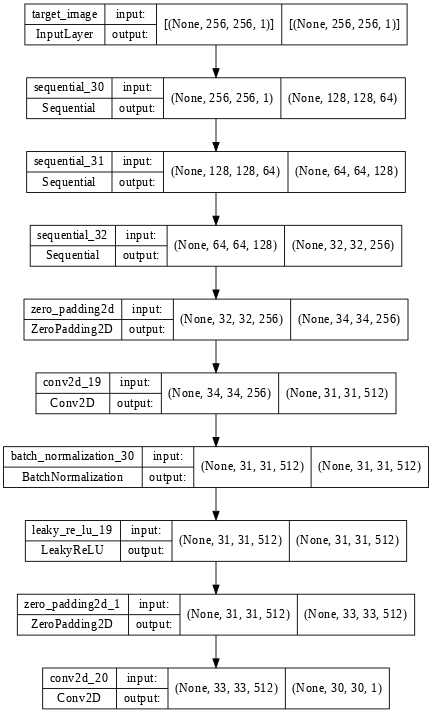

In [33]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

In [ ]:
disc_out = discriminator(gen_output, training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

NameError: ignored

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [34]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [57]:
mae = tf.keras.metrics.MeanAbsoluteError()
mae_loss = tf.keras.losses.MeanAbsoluteError()

In [84]:
generator = Generator()
generator.compile(optimizer=tf.keras.optimizers.Adam(1e-6, beta_1=0.5),
                  loss=mae_loss)
train_gen = data_generators['train']
val_gen = data_generators['validation']
generator.fit(train_gen.data_set, steps_per_epoch=10,
              validation_data=train_gen.data_set, epochs=50,
              validation_steps=len(val_gen))

Epoch 1/50
10/10 [==============================] - 7s 426ms/step - loss: 0.2343 - val_loss: nan
Epoch 2/50
10/10 [==============================] - 4s 435ms/step - loss: 0.2291 - val_loss: nan
Epoch 3/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.2302

KeyboardInterrupt: ignored

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [35]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
!mkdir -p training_checkpoints
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since
you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [37]:
def generate_images(model, input, tar):
  prediction = model(input, training=True)
  plt.figure(figsize=(10, 10))

  # print("Input ")
  # print(type(cbct_input))
  # print(tf.shape(cbct_input))
  # print("ground truth")
  # print(type(tar))
  # print(tf.shape(tar))
  display_list = [input[0], tar[0], prediction[0]]
  title = ['Input CBCT Image', 'Ground Truth', 'Predicted Image']
  
  plt.subplot(1, 3, 1)
  plt.title('Input Image')
  # Getting the pixel values in the [0, 1] range to plot.
  
  input = tf.squeeze(input,axis=0)
  inslice = getinput(input,1)
  
  plt.imshow(inslice)
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.title('Ground Truth')
  # Getting the pixel values in the [0, 1] range to plot.
  #plt.imshow(tf.squeeze(tar[0],axis=0))
  #tar = tf.cast(tar,tf.float32)
  plt.imshow(tf.squeeze(tar[0],axis=-1))
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.title('Predicted Image')
  
  tar = tf.squeeze(tar, axis=0)
  tar = tf.squeeze(tar, axis=-1)
  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  
  predvec = prediction[128,1:256]
  rtvec = tar[128,1:256]
  
  # predvec = prediction[1:256,128]
  # rtvec = rtimage[1:256,128]


  plt.plot(rtvec,'g')
  plt.title("Meas RT IMG (Green)")
  plt.plot(predvec,'b')

  # Getting the pixel values in the [0, 1] range to plot.
  #print(tf.shape(prediction))
  #prediction = tf.cast(prediction,tf.float32)
  #plt.imshow(tf.squeeze(prediction[0],axis=-1))
  #plt.axis('off')
  
  plt.show()

Test the function:

In [ ]:
for example in valid_dataset.take(1):
  input = example['input']
  print(tf.shape(input))
  rtimg = example['rtimg']
  #rtimg = tf.squeeze(rtimg, axis=0)
  generate_images(generator, input, rtimg)

NameError: ignored

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [38]:
log_dir="/content/drive/MyDrive/Colab Notebooks/logs/"
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/padding_jpeg" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

20220321-214749


In [39]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator(target, training=True)
    disc_generated_output = discriminator(gen_output, training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//500)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//500)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//500)
    tf.summary.scalar('disc_loss', disc_loss, step=step//500)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [ ]:
def fit(train_ds, test_ds, steps):
  iterator = iter(test_ds.take(1))
  example = next(iterator)
  ex_input = example['input']
  rtimg = example['rtimg']
  #rtimg = tf.squeeze(rtimg, axis=0)
  start = time.time()
  for step, (input_obj) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start} sec\n')
        start = time.time()

      generate_images(generator, ex_input, rtimg)
      print(f"Step: {step//1000}k")

    input = input_obj['input']
    target = input_obj['rtimg'] 
    train_step(input, target, step)

    # Training step
    if (step+1) % 100 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
def fit_new(train_generator, validation_generator, steps):
    validation_iterator = iter(validation_generator.data_set)
    train_iterator = iter(train_generator.data_set)
    for step in range(steps):
      if step % 1000 == 0:
          x, y = next(validation_iterator)
          generate_images(generator, x[0], y[0])
      x, y = next(train_iterator)
      input_image = x[0]
      target_image = y[0]
      train_step(input_image, target_image, step)
      # Training step
      if (step+1) % 100 == 0:
          print('.', end='', flush=True)
          print(step)
      # Save (checkpoint) the model every 5k steps
      if (step + 1) % 100 == 0:
          checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

Finally, run the training loop:

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Time taken for 1000 steps: 0.0037703514099121094 sec



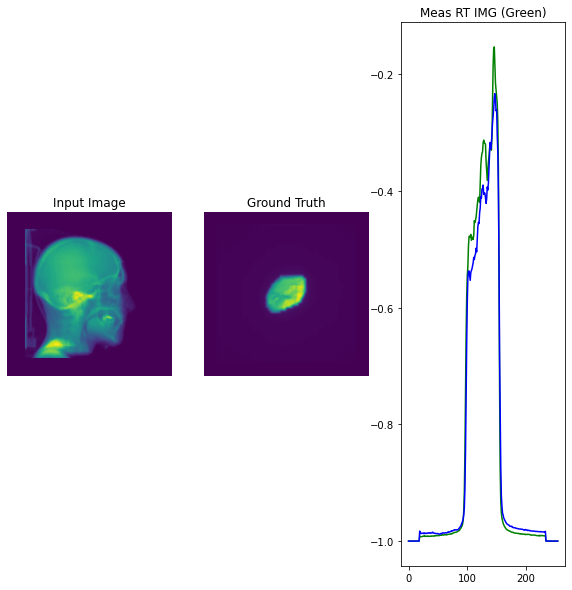

Step: 39k
..........

In [ ]:
fit(train_dataset, valid_dataset, steps=40000)

In [ ]:
#docs_infra: no_execute'
%reload_ext tensorboard
%tensorboard --logdir /content/notebooks/logs/fit/

If you want to share the TensorBoard results _publicly_, you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [ ]:
# display.IFrame(
#     src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
#     width="100%",
#     height="1000px")

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [ ]:
#os.listdir(checkpoint_dir)
#os.listdir(log_dir + '/fit')

In [ ]:
#Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [ ]:
generator.save('/content/drive/MyDrive/Colab Notebooks/3chan_lrgken_L1')

In [ ]:
gamma_options = {
    'dose_percent_threshold': 3,  # Try with 2%/2mm 
    'distance_mm_threshold': 3,
    'lower_percent_dose_cutoff': 10,
    'interp_fraction': 20,  # Should be 10 or more, see the paper referenced above
    'max_gamma': 2,
    'random_subset': None,  # Can be used to get quick pass rates
    'local_gamma': False,  # Change to false for global gamma
    'ram_available': 2**29  # 1/2 GB
}

In [ ]:
xepidmin = -215
xepidmax = 215
yepidmin = -215
yepidmax = 215
grid = 1.6797
xepid = np.arange(xepidmin,xepidmax,grid)
yepid = np.arange(yepidmin,yepidmax,grid)
coords = (yepid,xepid)

In [ ]:
testfiles = tf.io.gfile.glob('/content/drive/My Drive/train/nifti/fold4/12_4_35.*')
valid_data = load_data(testfiles, tf.estimator.ModeKeys.TRAIN, '/content/drive/My Drive/train/nifti/fold1')

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data))
valid_dataset = valid_dataset.batch(BATCH_SIZE)

In [ ]:
example = next(iter(valid_dataset))
input = example['input']
#print(tf.shape(cbct_input))
tar = example['rtimg']
prediction = generator(input, training=True) 

diff = tf.subtract(tar,prediction)
diff = tf.squeeze(diff, axis=0)
diffvec = diff[120,1:256]
tar = tf.squeeze(tar, axis=0)
tar = tf.squeeze(tar, axis=-1)
rtimage = tar+1

prediction = tf.squeeze(prediction, axis=0)
prediction = tf.squeeze(prediction, axis=-1)
prediction = prediction +1
 
plt.figure(figsize=(10, 10))
  
plt.subplot(2, 2, 1)
plt.imshow(rtimage)
plt.subplot(2, 2, 2)
plt.imshow(prediction)
  
predvec = prediction[128,1:256]
rtvec = rtimage[128,1:256]
  
#predvec = prediction[1:256,128]
#rtvec = rtimage[1:256,128]

plt.subplot(2, 2, 3)
plt.plot(rtvec,'g')
plt.title("Meas RT IMG (Green)")
plt.plot(predvec,'b')
print(str(example["fname"]))

gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options)
valid_gamma = gamma_test[~np.isnan(gamma_test)]

num_bins = (
    gamma_options['interp_fraction'] * gamma_options['max_gamma'])
bins = np.linspace(0, gamma_options['max_gamma'], num_bins + 1)

#gamma_no_noise = pymedphys.gamma(coords, rtimage, coords, prediction,**gamma_options)
plt.subplot(2, 2, 4)

plt.imshow( gamma_test, clim=(0, 2), cmap='coolwarm')

# plt.hist(valid_gamma, bins, density=True)
# plt.xlim([0, gamma_options['max_gamma']])
pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
plt.title(f"Local Gamma ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm) | Percent Pass: {pass_ratio*100:.2f} %")

In [ ]:
plt.imshow(gamma_test)

In [ ]:
all_ratios = np.zeros(len(list(valid_dataset)))
i = 0
for example in valid_dataset:
  tinp = example['input']
  ttar = example['rtimg']
  prediction = generator(tinp, training=True)
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar+1

  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  prediction = prediction +1
  gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options,quiet=True)
  valid_gamma = gamma_test[~np.isnan(gamma_test)]
  pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
  tf.print(example["fname"])
  print(pass_ratio)
  all_ratios[i] = pass_ratio
  i = i+1

print("mean " + str(np.mean(all_ratios)))
print("STD " + str(np.std(all_ratios)))
print("max " + str(np.max(all_ratios)))
print("min " + str(np.min(all_ratios)))
plt.hist(all_ratios)